# Classification Analysis of Earnings Estimates

This notebook contains all of the classification algorithms I applied to my data, which include Naive Bayes, Logistic Regression, SVM, Decision Trees, and Random Forests.

### Import relevant libraries and classifiers

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import re
from itertools import product

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, learning_curve
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_curve, auc, classification_report, precision_recall_curve, log_loss, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier

from mlxtend.plotting import plot_decision_regions

np.random.seed(42)

%matplotlib inline

pd.set_option('max_rows', 100)
pd.set_option('max_columns', 40)
pd.set_option('precision', 3)

### Import master (merged) dataframe

Vectorize sectors (total of 11) and make general ticker name

In [2]:
with open('/Users/samfunk/ds/metis/project_mcnulty/datafiles/master_df.pkl', 'rb') as f:
    master = pickle.load(f)
    dummies = pd.get_dummies(master.true_sector)
    le_sector = LabelEncoder()
    le_sector.fit(master.true_sector)
    master['sector_classes'] = le_sector.transform(master.true_sector)
    
    master['ticker_string'] = master['ticker_quarter'].apply(lambda x: re.search(r'([A-Z]*)', x)[1])

## Exploratory Data Analysis

Look at correlations for raw and segmented features

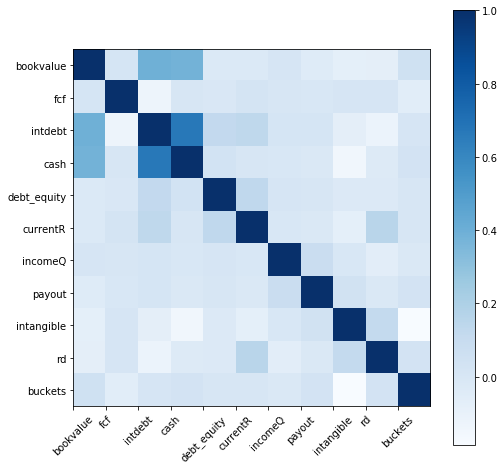

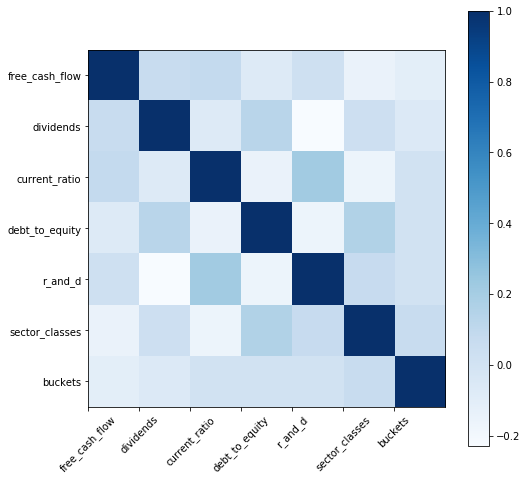

In [3]:
raw_features = ['bookvalue', 'fcf', 'intdebt', 'cash', 'debt_equity', 'currentR', 'incomeQ', 'payout', 'intangible', 'rd']
segmented_features = ['free_cash_flow', 'dividends', 'current_ratio', 'debt_to_equity', 'r_and_d', 'sector_classes']
target = 'buckets'

def correlations(feature_set):
    raw_df = master.loc[:, feature_set].join(master.loc[:, 'buckets'])
    corr = raw_df.corr();

    plt.figure(figsize=(8,8))
    ax = plt.gca()
    plt.imshow(corr, cmap='Blues', interpolation='nearest')
    cbar = plt.colorbar()
    plt.grid(False)
    plt.yticks(np.arange(corr.shape[1]))
    plt.xticks(np.arange(corr.shape[0])-0.5, rotation=45)
    ax.set_xticklabels(list(raw_df.columns), minor=False)
    ax.set_yticklabels(list(raw_df.columns), minor=False);

correlations(raw_features)
correlations(segmented_features)

Graph scatter plots of raw features vs. one another (looking for patterns and identifiable distributions)

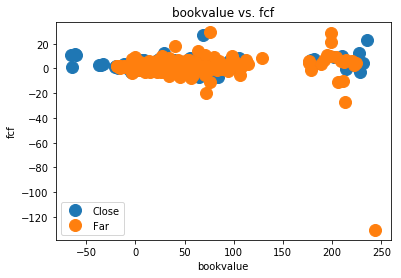

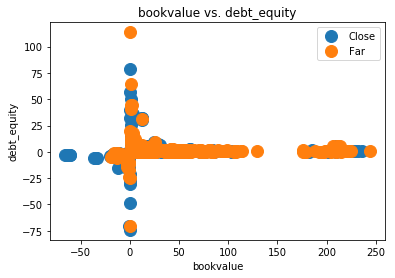

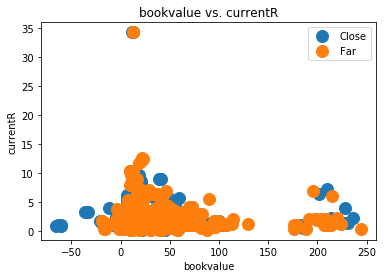

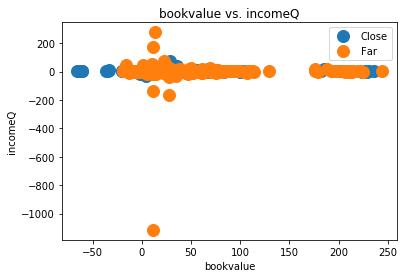

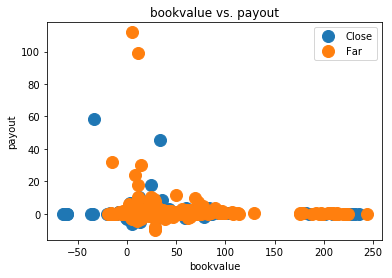

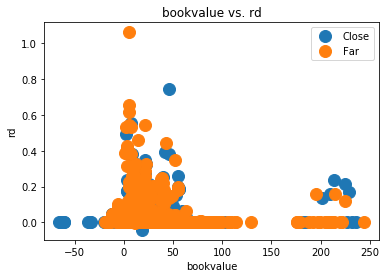

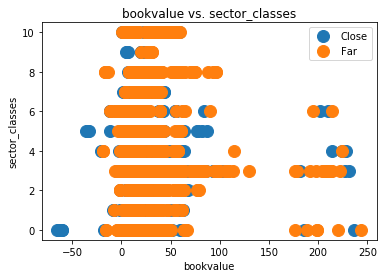

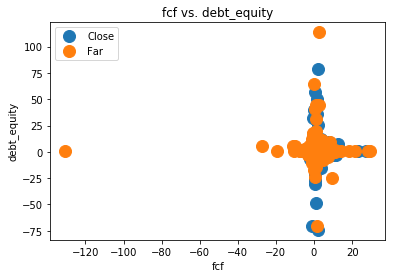

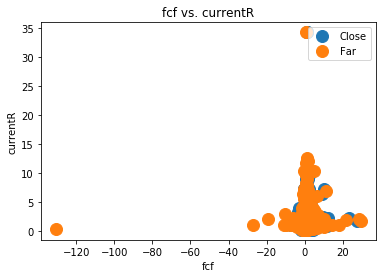

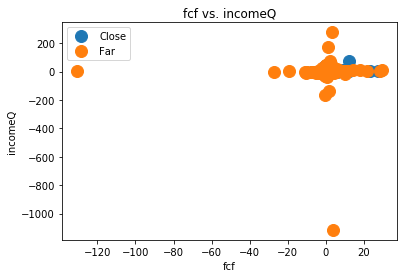

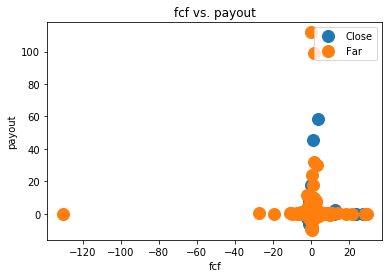

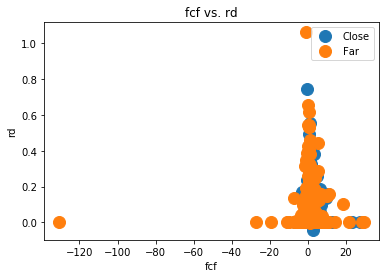

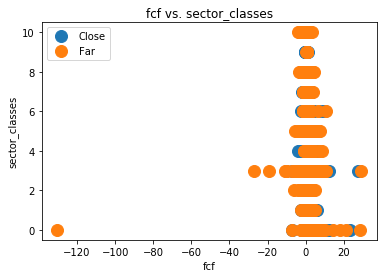

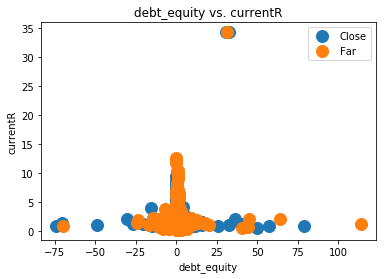

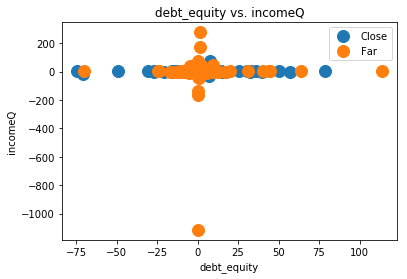

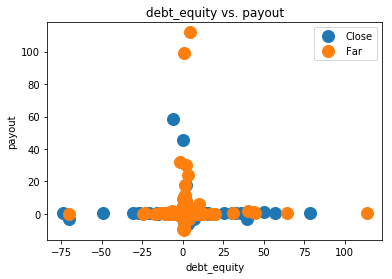

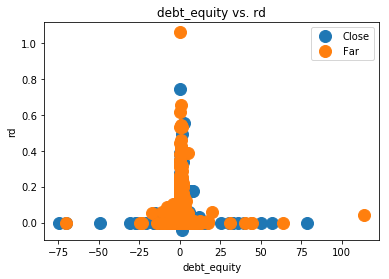

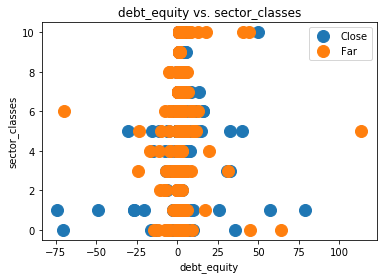

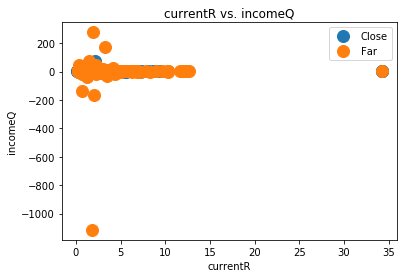

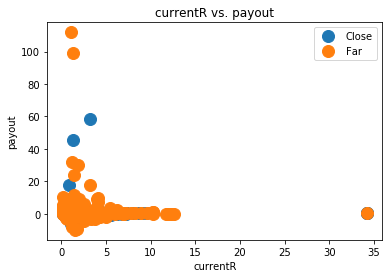

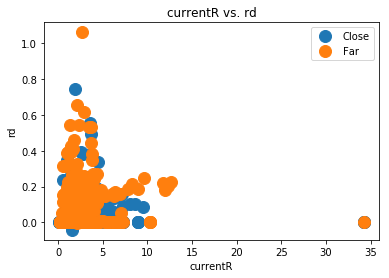

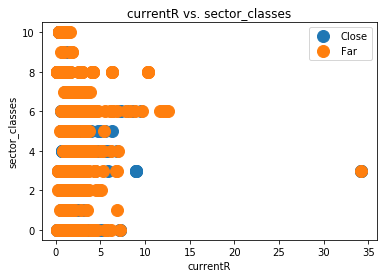

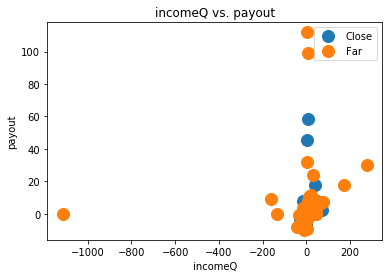

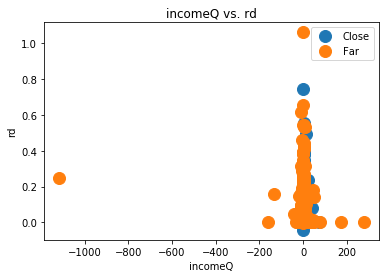

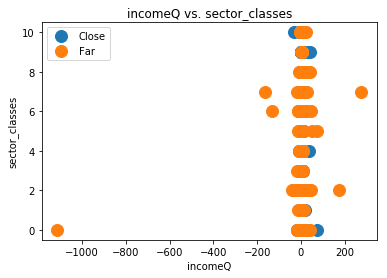

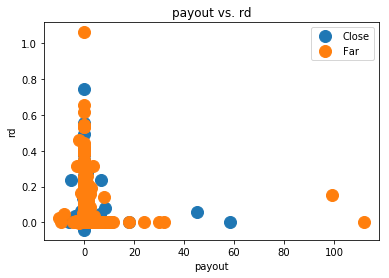

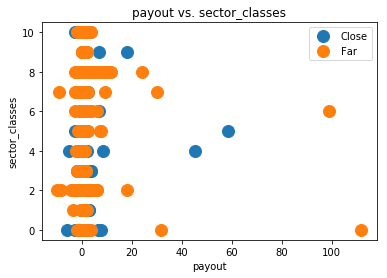

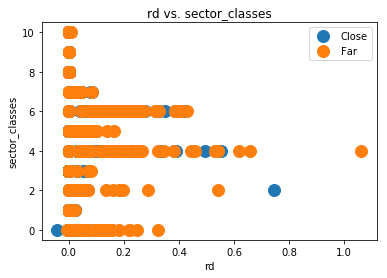

In [4]:
import itertools
combinations = [x for x in itertools.combinations(['bookvalue', 'fcf', 'debt_equity', 'currentR', 'incomeQ', 'payout', 'rd', 'sector_classes'], 2)]
targets = {0: 'Close', 1: 'Far'}
for x,y in combinations:
    groups = master.groupby('buckets')
    fig, ax = plt.subplots()
    
    for name, group in groups:
        ax.plot(group[x], group[y], marker='o', linestyle='', ms=12, label=targets[name])
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title('%s vs. %s' % (x, y))
    plt.legend()
    #plt.scatter(master[('return', 'mean')], master[('return', 'std')])
    plt.show()

# Classifiers

Make sure to run plotting functions at the bottom first

In [5]:
shuffle = master.sample(frac=1, random_state=42) #randomize dataframe

### Feature and target selection

Create list of feature combintions which always contain the continuous versions of bookvalue and the categorical versions of payout ratio (dividends), research and development, and sector classes

In [6]:
feature_array = [['bookvalue'], ['fcf', 'free_cash_flow'], ['debt_equity', 'debt_to_equity'], ['currentR', 'current_ratio'], ['incomeQ', 'income_quality'], ['dividends'], ['r_and_d'], ['sector_classes']]
feature_list = list(product(*feature_array))
target = shuffle.buckets

## Plot Confusion Matrix, ROC, Precision/Recall , and Learning Curves

In [7]:
def calculate_confusion_matrix(best_estimator, X_train, Y_train, X_test, Y_test):

    train_acc = best_estimator.score(X_train, Y_train)
    test_acc = best_estimator.score(X_test, Y_test)
    print("Training Data Accuracy: %0.2f" %(train_acc))
    print("Test Data Accuracy:     %0.2f" %(test_acc))

    y_true = Y_test
    y_pred = best_estimator.predict(X_test)
    conf = confusion_matrix(y_true, y_pred, labels=None)
    
    return conf

def plot_confusion_matrix(cm, classes=['Close', 'Far'],
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [8]:
def plot_roc_curve(Y_test, y_score):

    fpr, tpr,_ = roc_curve(Y_test, y_score)
    roc_auc = auc(fpr, tpr)

    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right");
    plt.show();
    
def plot_precision_recall(best_estimator, X_test, Y_test):    
    yprobpred = best_estimator.predict_proba(X_test)
    precision, recall, _ = precision_recall_curve(Y_test, yprobpred[:,1])
    lw = 2
    plt.plot(precision, recall, color='darkorange',
             lw=lw, label='P-R curve, Class 1 (area = %0.2f)' % roc_auc)
    #plt.xlim([0.4, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="upper right");
    plt.show();

In [9]:
def plot_learning_curve(best_estimator, title, X, y, ylim=None, cv=3,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title("%s Learning Curve" % title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        best_estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()

### Classifier function (scaled variant models)

In [10]:
def classifier(model, title, params, feature_array, scaling=True, scoring='accuracy', linsvc=False, single_feature_set=False, target=shuffle.loc[:, 'buckets']):
    '''
    Classification function for models that require scaled data (i.e. KNN, Logistic Regression, SVM, and Naive Bayes)
    Uses grid search to find best estimator for desired optimization score
    ---
    IN:
        model = classifier with given paraemters (i.e. random state, class_weights, etc)
        params = parameter grid for grid search cross validation
        feature_array = either a list of feature sets or a single feature set (independent variables)
        single_feature_set = determines whether feature_array is a list of lists and should loop through each feature set,
                             if True, then feature_array is a single set of features and loop is not utilized
        target = earnings surprise buckets (dependent variable)
    OUT:
        Prints feature list, model parameters, accuracy, precision, recall, f1 score, ROC curve w/ AUC, and confusion matrix
    '''
    
    if  single_feature_set:
        feature_array = [feature_array, ('null')]
    
    for ind, feature in enumerate(feature_array):

        X = np.array(shuffle.loc[:, feature])
        y = np.array(target)

        X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.25, random_state=0)
        
        if scaling:
            ss_split = StandardScaler()
            ss_split.fit(X_train)
            X_train = ss_split.transform(X_train)
            X_test = ss_split.fit_transform(X_test)
        
        clf = GridSearchCV(model, params, scoring=scoring, cv=5, n_jobs=-1)
        clf.fit(X_train, Y_train)
        best_est = clf.best_estimator_
        y_pred = best_est.predict(X_test)   
        
        print('Feature set: {}'.format(feature))
        print('Parameters: {}'.format(best_est.get_params()))

        cm = calculate_confusion_matrix(best_est, X_train, Y_train, X_test, Y_test)
        plot_confusion_matrix(cm)
        plt.show()

        print('Accuracy: %0.4f' % accuracy_score(Y_test, y_pred))
        print(classification_report(Y_test, y_pred, target_names=["Close", "Far"]))
        
        if not linsvc: 
            y_score = best_est.predict_proba(X_test_std)[:,1]
            fpr, tpr, _ = roc_curve(Y_test, y_score)
            roc_auc = auc(fpr, tpr)
            plot_roc_curve(Y_test, y_score)
            
        plot_learning_curve(best_est, title, X, y)
        
        if single_feature_set:
            break

## Naive Bayes

Most simplistic model. Does not perform well.

In [11]:
for features in feature_list:
    X = np.array(shuffle.loc[:, features])
    y = np.array(shuffle.buckets)

    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.25, random_state=0)

    ss_split = StandardScaler()
    ss_split.fit(X_train)
    X_train_std = ss_split.transform(X_train)
    X_test_std = ss_split.fit_transform(X_test)

    gnb = GaussianNB()
    gnb.fit(X_train_std, Y_train)
    y_pred = gnb.predict(X_test_std)
    print(features)
    print(accuracy_score(Y_test, y_pred))
    print(classification_report(Y_test, y_pred, target_names=["Close", "Far"]))

('bookvalue', 'fcf', 'debt_equity', 'currentR', 'incomeQ', 'dividends', 'r_and_d', 'sector_classes')
0.555785123967
             precision    recall  f1-score   support

      Close       0.47      0.78      0.59       197
        Far       0.73      0.40      0.52       287

avg / total       0.62      0.56      0.55       484

('bookvalue', 'fcf', 'debt_equity', 'currentR', 'income_quality', 'dividends', 'r_and_d', 'sector_classes')
0.512396694215
             precision    recall  f1-score   support

      Close       0.43      0.66      0.52       197
        Far       0.64      0.41      0.50       287

avg / total       0.56      0.51      0.51       484

('bookvalue', 'fcf', 'debt_equity', 'current_ratio', 'incomeQ', 'dividends', 'r_and_d', 'sector_classes')
0.54958677686
             precision    recall  f1-score   support

      Close       0.47      0.79      0.59       197
        Far       0.73      0.38      0.50       287

avg / total       0.62      0.55      0.54       4

## Logistic Regression

None of the feature sets performed particularly well with Logistic Regression. This suggests the data may not follow a sigmoidal pattern. Other classification methods may prove to be more effective.

Feature set: ('bookvalue', 'fcf', 'debt_equity', 'currentR', 'incomeQ', 'dividends', 'r_and_d', 'sector_classes')
Parameters: {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 100, 'multi_class': 'ovr', 'n_jobs': 1, 'penalty': 'l2', 'random_state': 0, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Training Data Accuracy: 0.56
Test Data Accuracy:     0.55


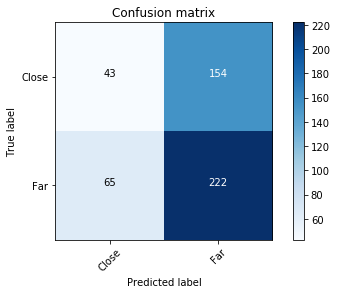

Accuracy: 0.5475
             precision    recall  f1-score   support

      Close       0.40      0.22      0.28       197
        Far       0.59      0.77      0.67       287

avg / total       0.51      0.55      0.51       484



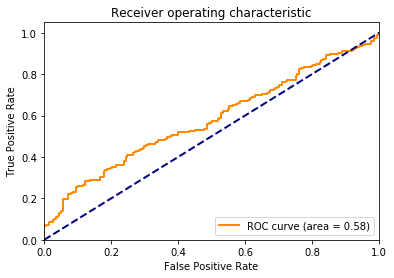

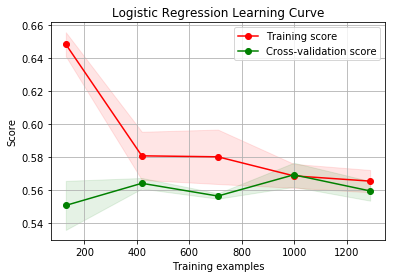

Feature set: ('bookvalue', 'fcf', 'debt_equity', 'currentR', 'income_quality', 'dividends', 'r_and_d', 'sector_classes')
Parameters: {'C': 0.001, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 100, 'multi_class': 'ovr', 'n_jobs': 1, 'penalty': 'l2', 'random_state': 0, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Training Data Accuracy: 0.57
Test Data Accuracy:     0.55


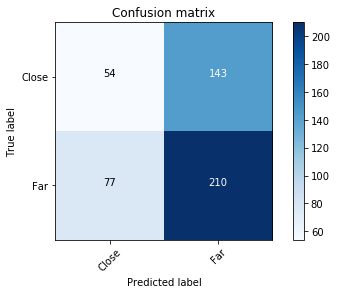

Accuracy: 0.5455
             precision    recall  f1-score   support

      Close       0.41      0.27      0.33       197
        Far       0.59      0.73      0.66       287

avg / total       0.52      0.55      0.52       484



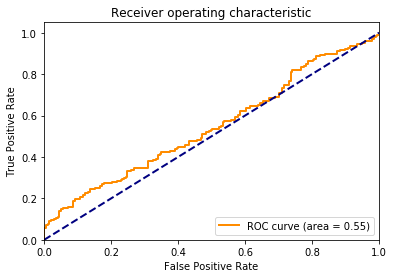

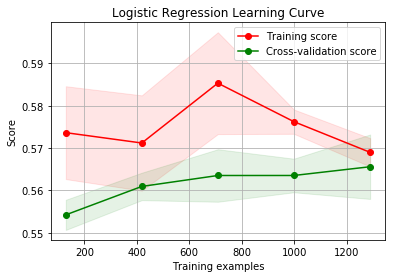

Feature set: ('bookvalue', 'fcf', 'debt_equity', 'current_ratio', 'incomeQ', 'dividends', 'r_and_d', 'sector_classes')
Parameters: {'C': 0.10000000000000001, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 100, 'multi_class': 'ovr', 'n_jobs': 1, 'penalty': 'l1', 'random_state': 0, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Training Data Accuracy: 0.57
Test Data Accuracy:     0.55


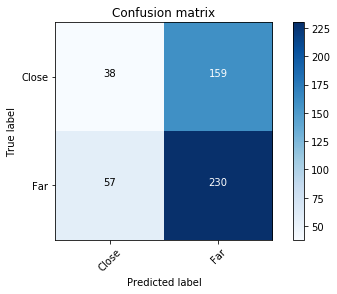

Accuracy: 0.5537
             precision    recall  f1-score   support

      Close       0.40      0.19      0.26       197
        Far       0.59      0.80      0.68       287

avg / total       0.51      0.55      0.51       484



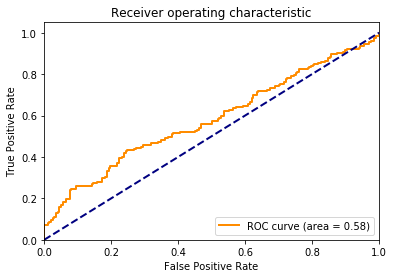

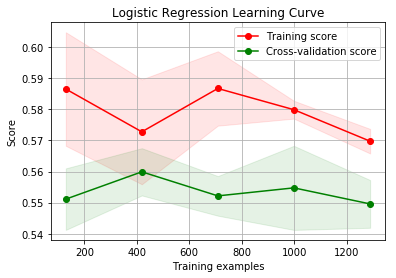

Feature set: ('bookvalue', 'fcf', 'debt_equity', 'current_ratio', 'income_quality', 'dividends', 'r_and_d', 'sector_classes')
Parameters: {'C': 0.01, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 100, 'multi_class': 'ovr', 'n_jobs': 1, 'penalty': 'l2', 'random_state': 0, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Training Data Accuracy: 0.57
Test Data Accuracy:     0.57


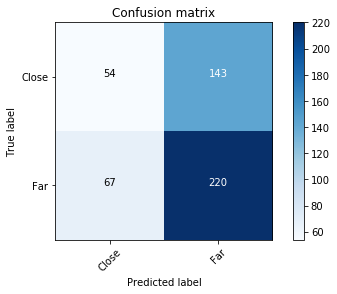

Accuracy: 0.5661
             precision    recall  f1-score   support

      Close       0.45      0.27      0.34       197
        Far       0.61      0.77      0.68       287

avg / total       0.54      0.57      0.54       484



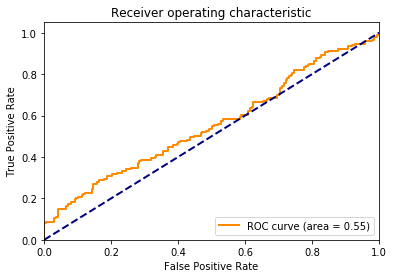

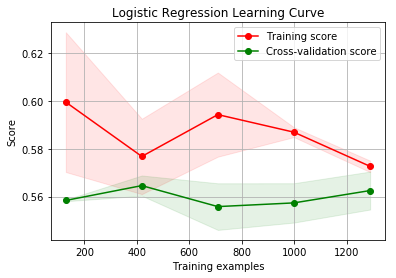

Feature set: ('bookvalue', 'fcf', 'debt_to_equity', 'currentR', 'incomeQ', 'dividends', 'r_and_d', 'sector_classes')
Parameters: {'C': 0.01, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 100, 'multi_class': 'ovr', 'n_jobs': 1, 'penalty': 'l2', 'random_state': 0, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Training Data Accuracy: 0.57
Test Data Accuracy:     0.55


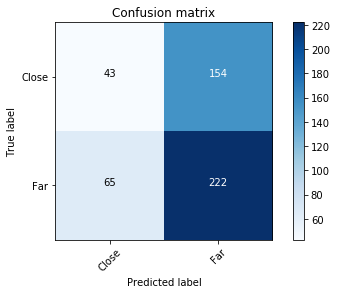

Accuracy: 0.5475
             precision    recall  f1-score   support

      Close       0.40      0.22      0.28       197
        Far       0.59      0.77      0.67       287

avg / total       0.51      0.55      0.51       484



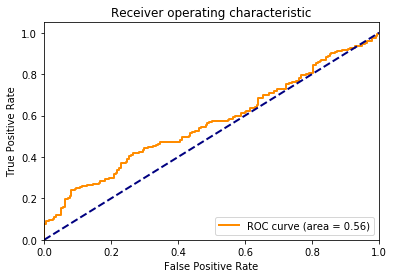

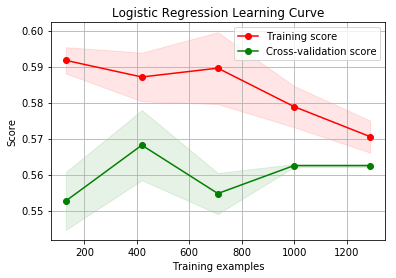

Feature set: ('bookvalue', 'fcf', 'debt_to_equity', 'currentR', 'income_quality', 'dividends', 'r_and_d', 'sector_classes')
Parameters: {'C': 0.10000000000000001, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 100, 'multi_class': 'ovr', 'n_jobs': 1, 'penalty': 'l2', 'random_state': 0, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Training Data Accuracy: 0.57
Test Data Accuracy:     0.55


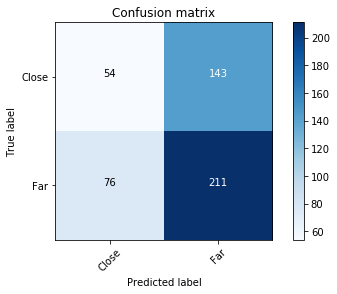

Accuracy: 0.5475
             precision    recall  f1-score   support

      Close       0.42      0.27      0.33       197
        Far       0.60      0.74      0.66       287

avg / total       0.52      0.55      0.52       484



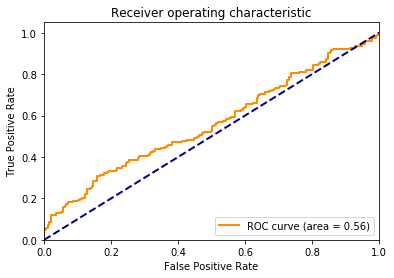

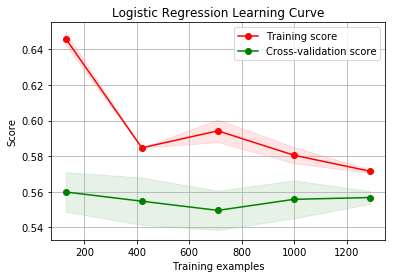

Feature set: ('bookvalue', 'fcf', 'debt_to_equity', 'current_ratio', 'incomeQ', 'dividends', 'r_and_d', 'sector_classes')
Parameters: {'C': 0.10000000000000001, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 100, 'multi_class': 'ovr', 'n_jobs': 1, 'penalty': 'l1', 'random_state': 0, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Training Data Accuracy: 0.57
Test Data Accuracy:     0.55


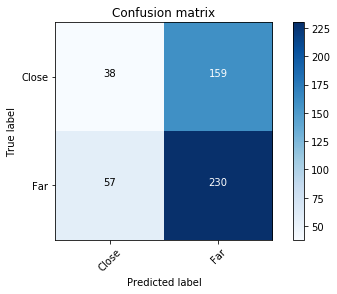

Accuracy: 0.5537
             precision    recall  f1-score   support

      Close       0.40      0.19      0.26       197
        Far       0.59      0.80      0.68       287

avg / total       0.51      0.55      0.51       484



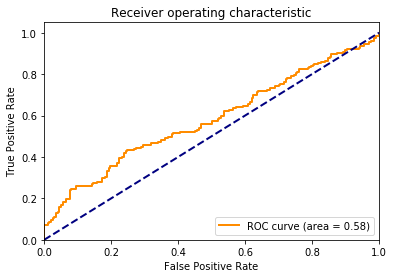

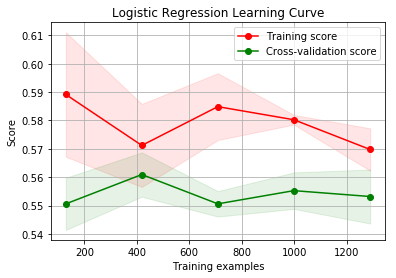

Feature set: ('bookvalue', 'fcf', 'debt_to_equity', 'current_ratio', 'income_quality', 'dividends', 'r_and_d', 'sector_classes')
Parameters: {'C': 10.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 100, 'multi_class': 'ovr', 'n_jobs': 1, 'penalty': 'l1', 'random_state': 0, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Training Data Accuracy: 0.57
Test Data Accuracy:     0.55


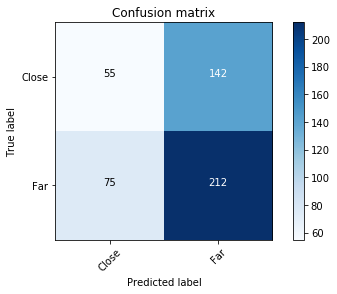

Accuracy: 0.5517
             precision    recall  f1-score   support

      Close       0.42      0.28      0.34       197
        Far       0.60      0.74      0.66       287

avg / total       0.53      0.55      0.53       484



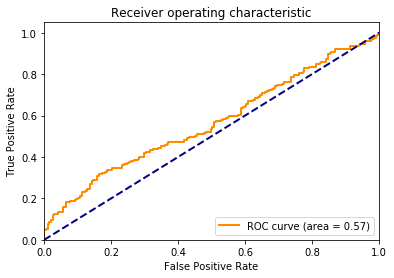

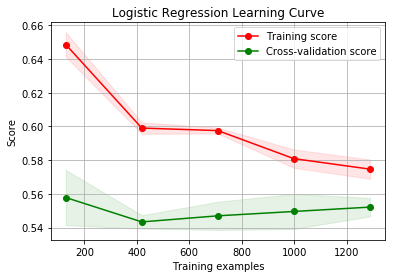

Feature set: ('bookvalue', 'free_cash_flow', 'debt_equity', 'currentR', 'incomeQ', 'dividends', 'r_and_d', 'sector_classes')
Parameters: {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 100, 'multi_class': 'ovr', 'n_jobs': 1, 'penalty': 'l2', 'random_state': 0, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Training Data Accuracy: 0.57
Test Data Accuracy:     0.55


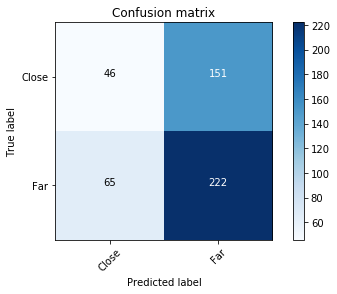

Accuracy: 0.5537
             precision    recall  f1-score   support

      Close       0.41      0.23      0.30       197
        Far       0.60      0.77      0.67       287

avg / total       0.52      0.55      0.52       484



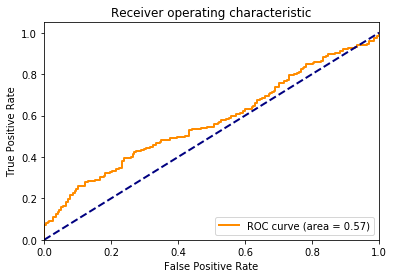

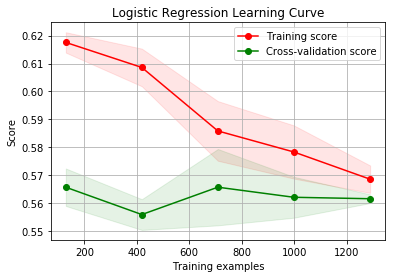

Feature set: ('bookvalue', 'free_cash_flow', 'debt_equity', 'currentR', 'income_quality', 'dividends', 'r_and_d', 'sector_classes')
Parameters: {'C': 0.01, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 100, 'multi_class': 'ovr', 'n_jobs': 1, 'penalty': 'l2', 'random_state': 0, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Training Data Accuracy: 0.57
Test Data Accuracy:     0.54


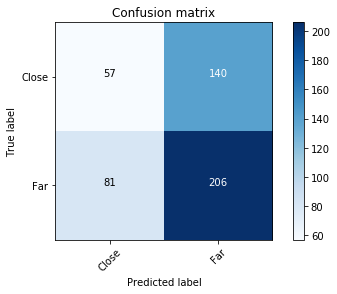

Accuracy: 0.5434
             precision    recall  f1-score   support

      Close       0.41      0.29      0.34       197
        Far       0.60      0.72      0.65       287

avg / total       0.52      0.54      0.52       484



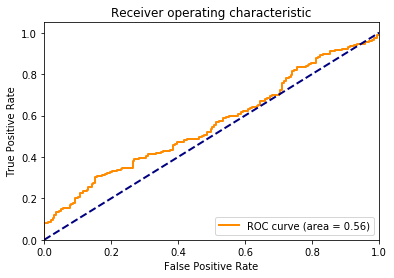

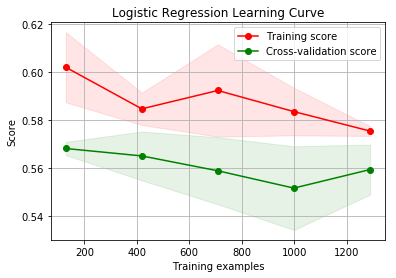

Feature set: ('bookvalue', 'free_cash_flow', 'debt_equity', 'current_ratio', 'incomeQ', 'dividends', 'r_and_d', 'sector_classes')
Parameters: {'C': 0.01, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 100, 'multi_class': 'ovr', 'n_jobs': 1, 'penalty': 'l2', 'random_state': 0, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Training Data Accuracy: 0.57
Test Data Accuracy:     0.57


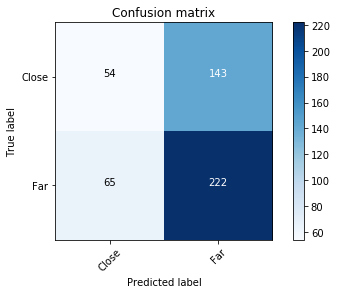

Accuracy: 0.5702
             precision    recall  f1-score   support

      Close       0.45      0.27      0.34       197
        Far       0.61      0.77      0.68       287

avg / total       0.55      0.57      0.54       484



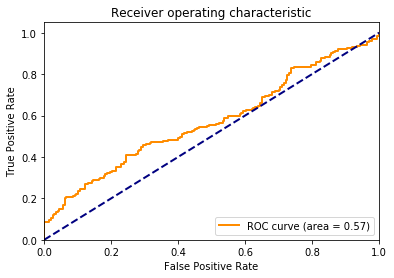

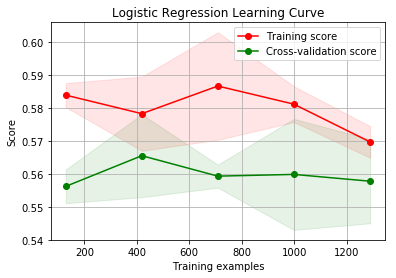

Feature set: ('bookvalue', 'free_cash_flow', 'debt_equity', 'current_ratio', 'income_quality', 'dividends', 'r_and_d', 'sector_classes')
Parameters: {'C': 0.01, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 100, 'multi_class': 'ovr', 'n_jobs': 1, 'penalty': 'l2', 'random_state': 0, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Training Data Accuracy: 0.57
Test Data Accuracy:     0.54


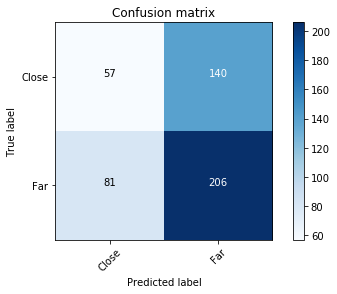

Accuracy: 0.5434
             precision    recall  f1-score   support

      Close       0.41      0.29      0.34       197
        Far       0.60      0.72      0.65       287

avg / total       0.52      0.54      0.52       484



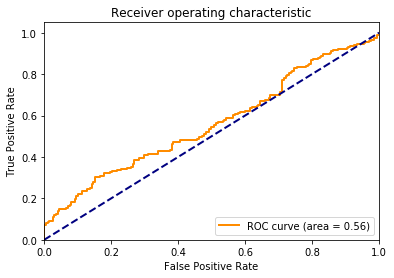

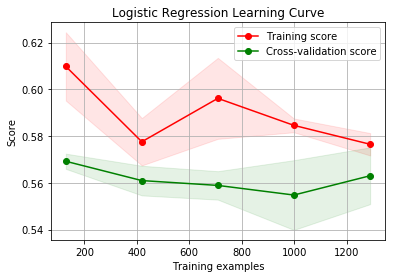

Feature set: ('bookvalue', 'free_cash_flow', 'debt_to_equity', 'currentR', 'incomeQ', 'dividends', 'r_and_d', 'sector_classes')
Parameters: {'C': 0.01, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 100, 'multi_class': 'ovr', 'n_jobs': 1, 'penalty': 'l2', 'random_state': 0, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Training Data Accuracy: 0.57
Test Data Accuracy:     0.55


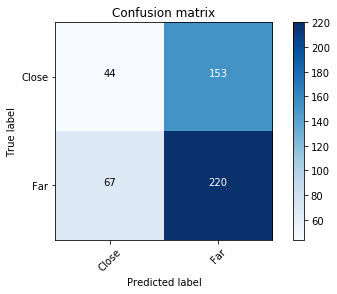

Accuracy: 0.5455
             precision    recall  f1-score   support

      Close       0.40      0.22      0.29       197
        Far       0.59      0.77      0.67       287

avg / total       0.51      0.55      0.51       484



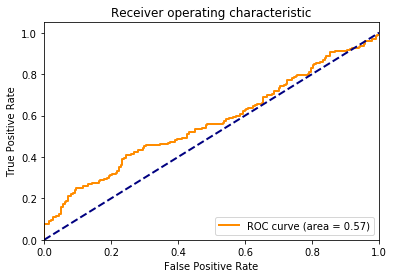

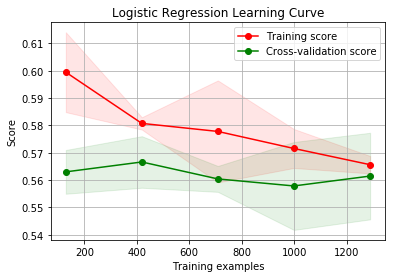

Feature set: ('bookvalue', 'free_cash_flow', 'debt_to_equity', 'currentR', 'income_quality', 'dividends', 'r_and_d', 'sector_classes')
Parameters: {'C': 0.10000000000000001, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 100, 'multi_class': 'ovr', 'n_jobs': 1, 'penalty': 'l2', 'random_state': 0, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Training Data Accuracy: 0.57
Test Data Accuracy:     0.56


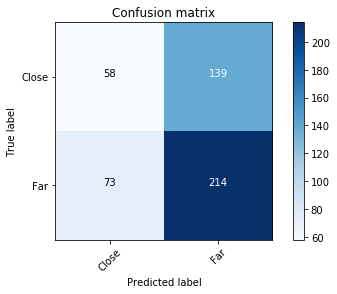

Accuracy: 0.5620
             precision    recall  f1-score   support

      Close       0.44      0.29      0.35       197
        Far       0.61      0.75      0.67       287

avg / total       0.54      0.56      0.54       484



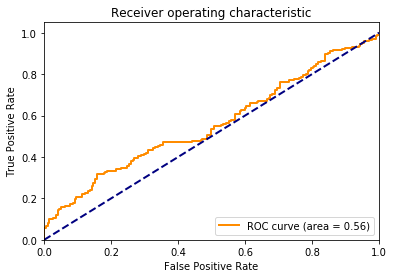

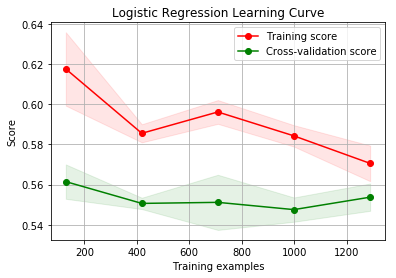

Feature set: ('bookvalue', 'free_cash_flow', 'debt_to_equity', 'current_ratio', 'incomeQ', 'dividends', 'r_and_d', 'sector_classes')
Parameters: {'C': 0.01, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 100, 'multi_class': 'ovr', 'n_jobs': 1, 'penalty': 'l2', 'random_state': 0, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Training Data Accuracy: 0.57
Test Data Accuracy:     0.55


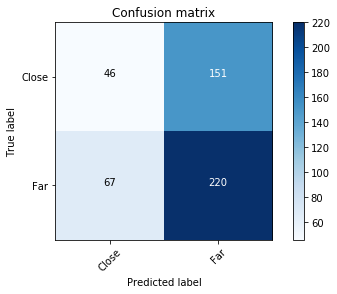

Accuracy: 0.5496
             precision    recall  f1-score   support

      Close       0.41      0.23      0.30       197
        Far       0.59      0.77      0.67       287

avg / total       0.52      0.55      0.52       484



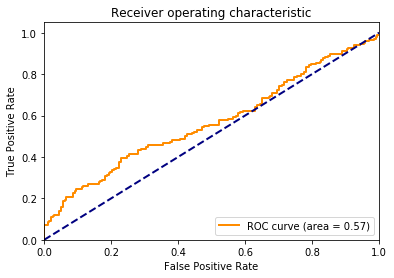

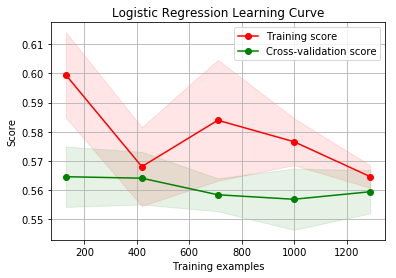

Feature set: ('bookvalue', 'free_cash_flow', 'debt_to_equity', 'current_ratio', 'income_quality', 'dividends', 'r_and_d', 'sector_classes')
Parameters: {'C': 0.10000000000000001, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 100, 'multi_class': 'ovr', 'n_jobs': 1, 'penalty': 'l1', 'random_state': 0, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Training Data Accuracy: 0.58
Test Data Accuracy:     0.57


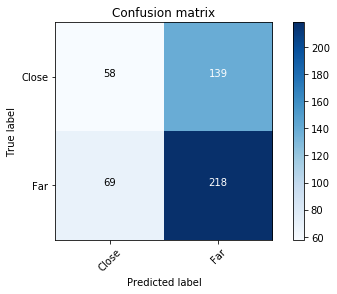

Accuracy: 0.5702
             precision    recall  f1-score   support

      Close       0.46      0.29      0.36       197
        Far       0.61      0.76      0.68       287

avg / total       0.55      0.57      0.55       484



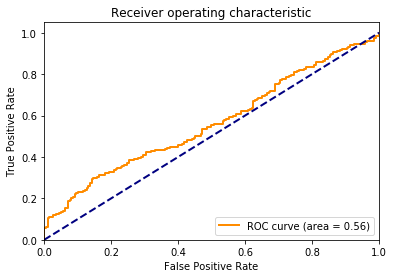

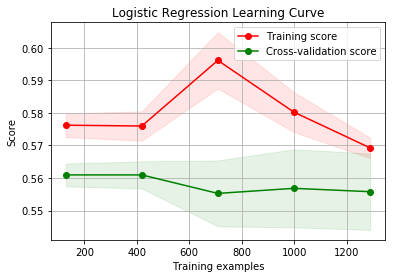

In [12]:
classifier(model=LogisticRegression(random_state=0),
           title='Logistic Regression',
           params={'C':np.logspace(-3,3,7), 'penalty':['l1','l2']},
           feature_array=feature_list,
           scoring='accuracy')

## SVM

### Linear

Outperforms the previous two but still not optimal. Below is the best feature set and paremters.

Feature set: ('bookvalue', 'fcf', 'debt_equity', 'currentR', 'incomeQ', 'dividends', 'r_and_d', 'sector_classes')
Parameters: {'C': 10.0, 'class_weight': None, 'dual': True, 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'squared_hinge', 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': 0, 'tol': 0.0001, 'verbose': 0}
Training Data Accuracy: 0.56
Test Data Accuracy:     0.57


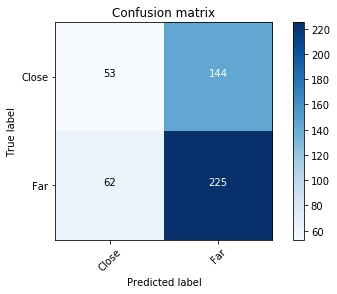

Accuracy: 0.5744
             precision    recall  f1-score   support

      Close       0.46      0.27      0.34       197
        Far       0.61      0.78      0.69       287

avg / total       0.55      0.57      0.55       484



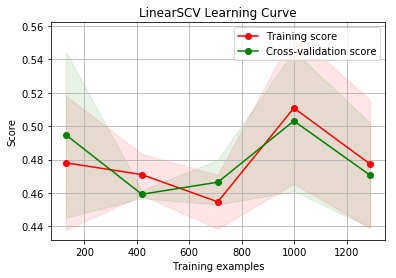

Feature set: ('bookvalue', 'fcf', 'debt_equity', 'currentR', 'income_quality', 'dividends', 'r_and_d', 'sector_classes')
Parameters: {'C': 0.001, 'class_weight': None, 'dual': True, 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'hinge', 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': 0, 'tol': 0.0001, 'verbose': 0}
Training Data Accuracy: 0.56
Test Data Accuracy:     0.55


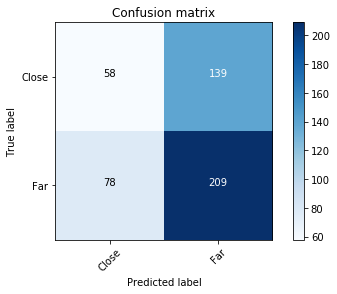

Accuracy: 0.5517
             precision    recall  f1-score   support

      Close       0.43      0.29      0.35       197
        Far       0.60      0.73      0.66       287

avg / total       0.53      0.55      0.53       484



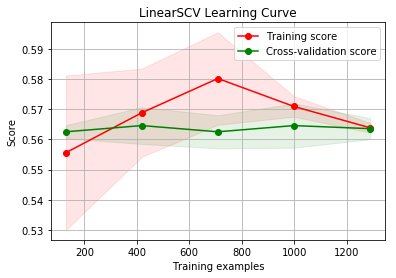

Feature set: ('bookvalue', 'fcf', 'debt_equity', 'current_ratio', 'incomeQ', 'dividends', 'r_and_d', 'sector_classes')
Parameters: {'C': 10.0, 'class_weight': None, 'dual': True, 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'squared_hinge', 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': 0, 'tol': 0.0001, 'verbose': 0}
Training Data Accuracy: 0.57
Test Data Accuracy:     0.57


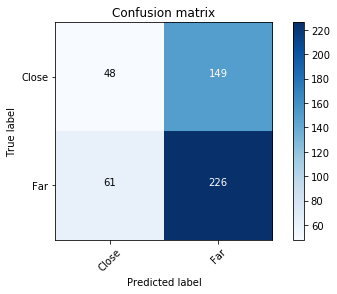

Accuracy: 0.5661
             precision    recall  f1-score   support

      Close       0.44      0.24      0.31       197
        Far       0.60      0.79      0.68       287

avg / total       0.54      0.57      0.53       484



Exception ignored in: <function WeakValueDictionary.__init__.<locals>.remove at 0x105623e18>
Traceback (most recent call last):
  File "/Users/samfunk/anaconda3/lib/python3.6/weakref.py", line 109, in remove
    def remove(wr, selfref=ref(self), _atomic_removal=_remove_dead_weakref):
KeyboardInterrupt


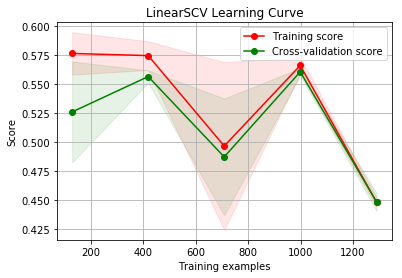

Feature set: ('bookvalue', 'fcf', 'debt_equity', 'current_ratio', 'income_quality', 'dividends', 'r_and_d', 'sector_classes')
Parameters: {'C': 10.0, 'class_weight': None, 'dual': True, 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'squared_hinge', 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': 0, 'tol': 0.0001, 'verbose': 0}
Training Data Accuracy: 0.57
Test Data Accuracy:     0.55


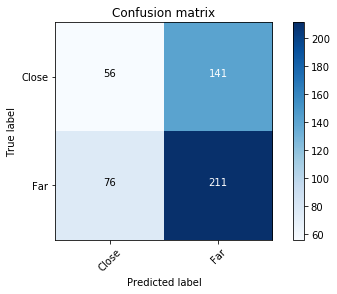

Accuracy: 0.5517
             precision    recall  f1-score   support

      Close       0.42      0.28      0.34       197
        Far       0.60      0.74      0.66       287

avg / total       0.53      0.55      0.53       484



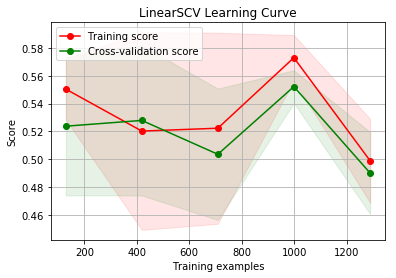

Feature set: ('bookvalue', 'fcf', 'debt_to_equity', 'currentR', 'incomeQ', 'dividends', 'r_and_d', 'sector_classes')
Parameters: {'C': 10.0, 'class_weight': None, 'dual': True, 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'squared_hinge', 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': 0, 'tol': 0.0001, 'verbose': 0}
Training Data Accuracy: 0.57
Test Data Accuracy:     0.58


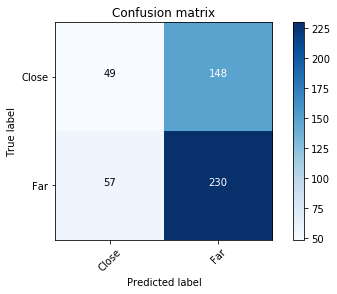

Accuracy: 0.5764
             precision    recall  f1-score   support

      Close       0.46      0.25      0.32       197
        Far       0.61      0.80      0.69       287

avg / total       0.55      0.58      0.54       484



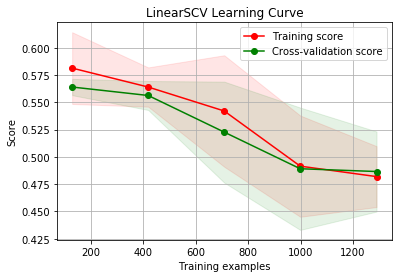

Feature set: ('bookvalue', 'fcf', 'debt_to_equity', 'currentR', 'income_quality', 'dividends', 'r_and_d', 'sector_classes')
Parameters: {'C': 0.10000000000000001, 'class_weight': None, 'dual': True, 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'squared_hinge', 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': 0, 'tol': 0.0001, 'verbose': 0}
Training Data Accuracy: 0.57
Test Data Accuracy:     0.55


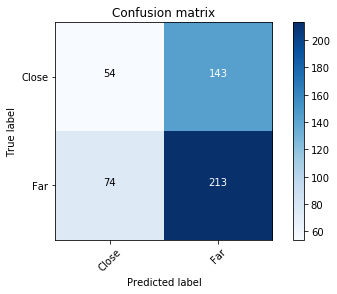

Accuracy: 0.5517
             precision    recall  f1-score   support

      Close       0.42      0.27      0.33       197
        Far       0.60      0.74      0.66       287

avg / total       0.53      0.55      0.53       484



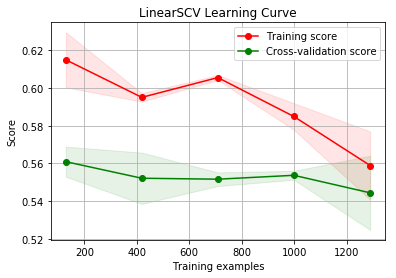

Feature set: ('bookvalue', 'fcf', 'debt_to_equity', 'current_ratio', 'incomeQ', 'dividends', 'r_and_d', 'sector_classes')
Parameters: {'C': 0.001, 'class_weight': None, 'dual': True, 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'squared_hinge', 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': 0, 'tol': 0.0001, 'verbose': 0}
Training Data Accuracy: 0.57
Test Data Accuracy:     0.55


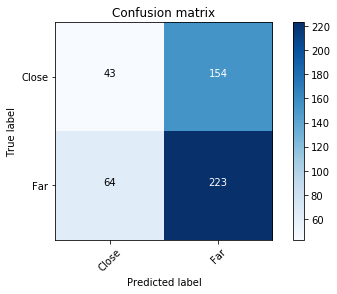

Accuracy: 0.5496
             precision    recall  f1-score   support

      Close       0.40      0.22      0.28       197
        Far       0.59      0.78      0.67       287

avg / total       0.51      0.55      0.51       484



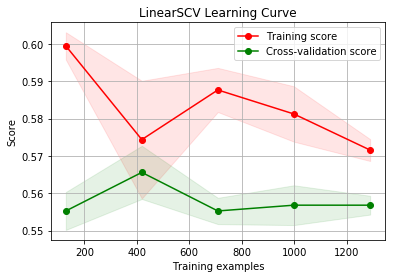

Feature set: ('bookvalue', 'fcf', 'debt_to_equity', 'current_ratio', 'income_quality', 'dividends', 'r_and_d', 'sector_classes')
Parameters: {'C': 0.01, 'class_weight': None, 'dual': True, 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'hinge', 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': 0, 'tol': 0.0001, 'verbose': 0}
Training Data Accuracy: 0.57
Test Data Accuracy:     0.57


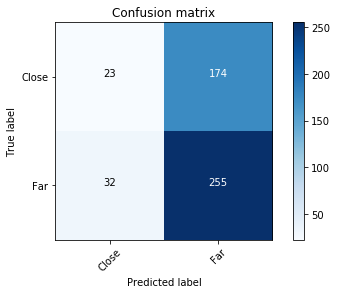

Accuracy: 0.5744
             precision    recall  f1-score   support

      Close       0.42      0.12      0.18       197
        Far       0.59      0.89      0.71       287

avg / total       0.52      0.57      0.50       484



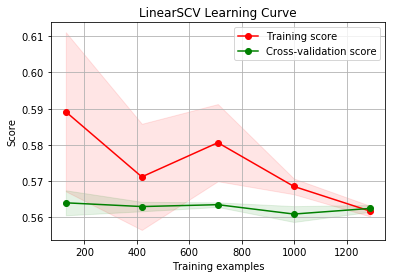

Feature set: ('bookvalue', 'free_cash_flow', 'debt_equity', 'currentR', 'incomeQ', 'dividends', 'r_and_d', 'sector_classes')
Parameters: {'C': 0.10000000000000001, 'class_weight': None, 'dual': True, 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'squared_hinge', 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': 0, 'tol': 0.0001, 'verbose': 0}
Training Data Accuracy: 0.56
Test Data Accuracy:     0.55


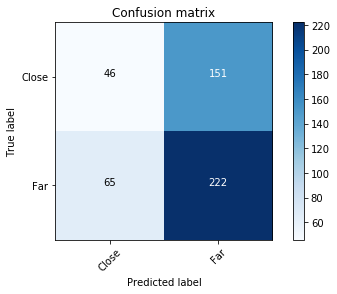

Accuracy: 0.5537
             precision    recall  f1-score   support

      Close       0.41      0.23      0.30       197
        Far       0.60      0.77      0.67       287

avg / total       0.52      0.55      0.52       484



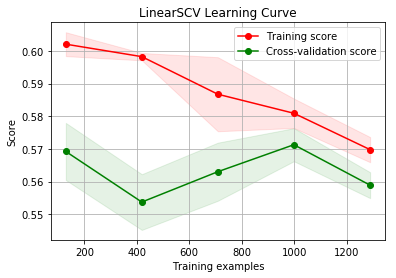

Feature set: ('bookvalue', 'free_cash_flow', 'debt_equity', 'currentR', 'income_quality', 'dividends', 'r_and_d', 'sector_classes')
Parameters: {'C': 10.0, 'class_weight': None, 'dual': True, 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'squared_hinge', 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': 0, 'tol': 0.0001, 'verbose': 0}
Training Data Accuracy: 0.57
Test Data Accuracy:     0.57


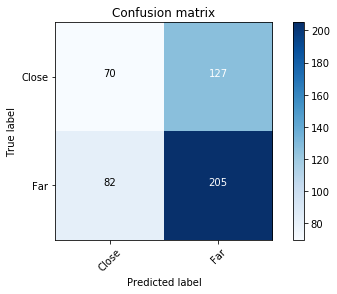

Accuracy: 0.5682
             precision    recall  f1-score   support

      Close       0.46      0.36      0.40       197
        Far       0.62      0.71      0.66       287

avg / total       0.55      0.57      0.56       484



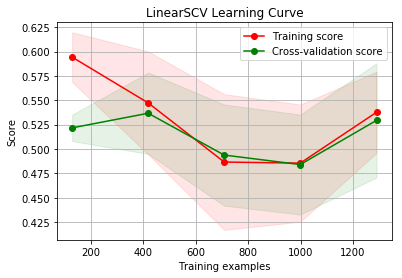

Feature set: ('bookvalue', 'free_cash_flow', 'debt_equity', 'current_ratio', 'incomeQ', 'dividends', 'r_and_d', 'sector_classes')
Parameters: {'C': 0.001, 'class_weight': None, 'dual': True, 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'hinge', 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': 0, 'tol': 0.0001, 'verbose': 0}
Training Data Accuracy: 0.57
Test Data Accuracy:     0.55


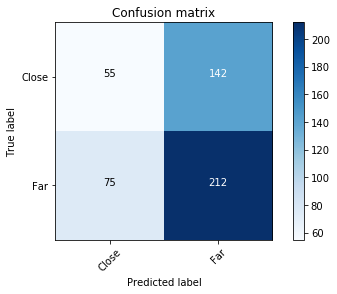

Accuracy: 0.5517
             precision    recall  f1-score   support

      Close       0.42      0.28      0.34       197
        Far       0.60      0.74      0.66       287

avg / total       0.53      0.55      0.53       484



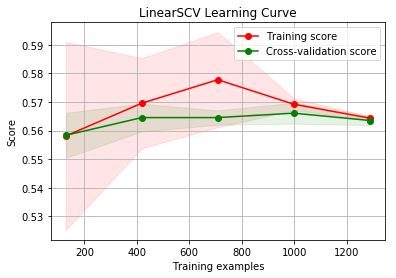

Feature set: ('bookvalue', 'free_cash_flow', 'debt_equity', 'current_ratio', 'income_quality', 'dividends', 'r_and_d', 'sector_classes')
Parameters: {'C': 0.001, 'class_weight': 'balanced', 'dual': True, 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'hinge', 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': 0, 'tol': 0.0001, 'verbose': 0}
Training Data Accuracy: 0.58
Test Data Accuracy:     0.53


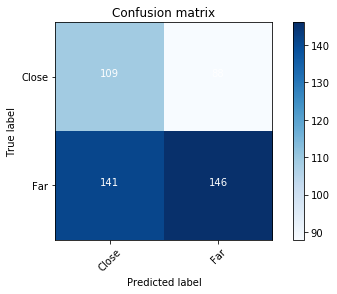

Accuracy: 0.5269
             precision    recall  f1-score   support

      Close       0.44      0.55      0.49       197
        Far       0.62      0.51      0.56       287

avg / total       0.55      0.53      0.53       484



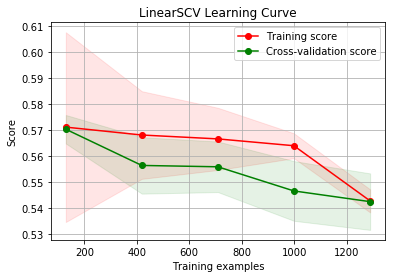

Feature set: ('bookvalue', 'free_cash_flow', 'debt_to_equity', 'currentR', 'incomeQ', 'dividends', 'r_and_d', 'sector_classes')
Parameters: {'C': 0.001, 'class_weight': None, 'dual': True, 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'squared_hinge', 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': 0, 'tol': 0.0001, 'verbose': 0}
Training Data Accuracy: 0.58
Test Data Accuracy:     0.55


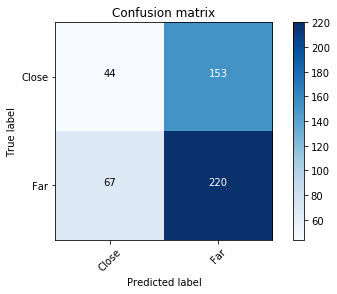

Accuracy: 0.5455
             precision    recall  f1-score   support

      Close       0.40      0.22      0.29       197
        Far       0.59      0.77      0.67       287

avg / total       0.51      0.55      0.51       484



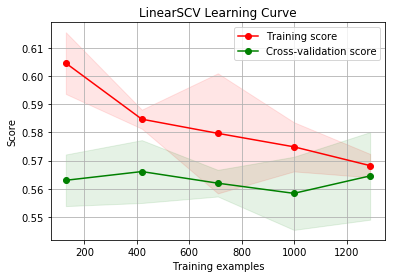

Feature set: ('bookvalue', 'free_cash_flow', 'debt_to_equity', 'currentR', 'income_quality', 'dividends', 'r_and_d', 'sector_classes')
Parameters: {'C': 10.0, 'class_weight': None, 'dual': True, 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'squared_hinge', 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': 0, 'tol': 0.0001, 'verbose': 0}
Training Data Accuracy: 0.57
Test Data Accuracy:     0.55


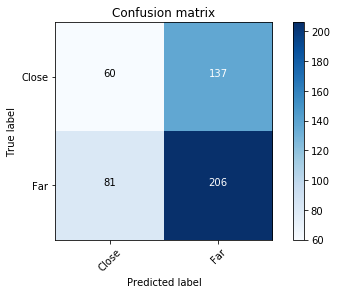

Accuracy: 0.5496
             precision    recall  f1-score   support

      Close       0.43      0.30      0.36       197
        Far       0.60      0.72      0.65       287

avg / total       0.53      0.55      0.53       484



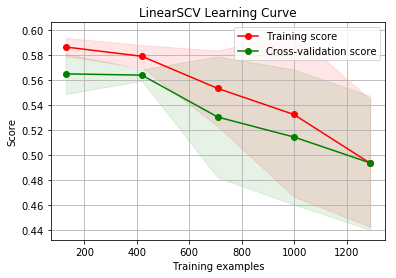

Feature set: ('bookvalue', 'free_cash_flow', 'debt_to_equity', 'current_ratio', 'incomeQ', 'dividends', 'r_and_d', 'sector_classes')
Parameters: {'C': 0.001, 'class_weight': None, 'dual': True, 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'hinge', 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': 0, 'tol': 0.0001, 'verbose': 0}
Training Data Accuracy: 0.57
Test Data Accuracy:     0.55


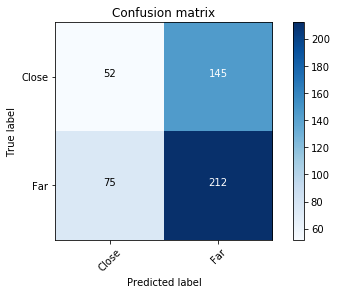

Accuracy: 0.5455
             precision    recall  f1-score   support

      Close       0.41      0.26      0.32       197
        Far       0.59      0.74      0.66       287

avg / total       0.52      0.55      0.52       484



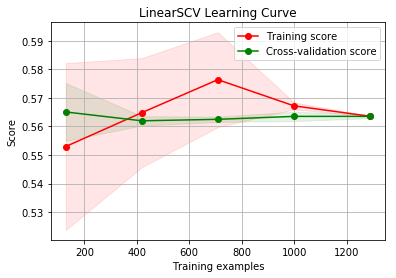

Feature set: ('bookvalue', 'free_cash_flow', 'debt_to_equity', 'current_ratio', 'income_quality', 'dividends', 'r_and_d', 'sector_classes')
Parameters: {'C': 0.001, 'class_weight': 'balanced', 'dual': True, 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'hinge', 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': 0, 'tol': 0.0001, 'verbose': 0}
Training Data Accuracy: 0.57
Test Data Accuracy:     0.51


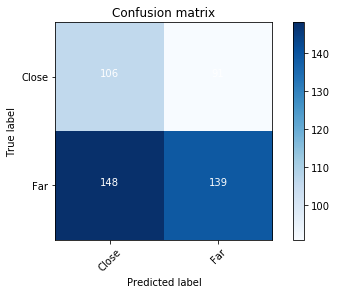

Accuracy: 0.5062
             precision    recall  f1-score   support

      Close       0.42      0.54      0.47       197
        Far       0.60      0.48      0.54       287

avg / total       0.53      0.51      0.51       484



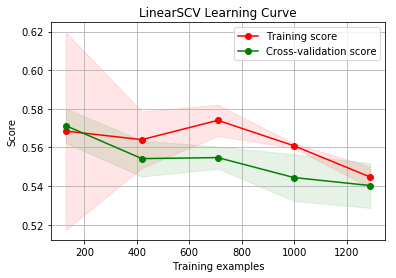

In [13]:
classifier(model = LinearSVC(random_state=0),
           title = 'LinearSCV',
           linsvc=True,
           params = dict(C=np.logspace(-3, 3, 7), loss=['hinge','squared_hinge'], class_weight=[None, 'balanced']),
           feature_array = feature_list,
           scoring = 'accuracy')

In [ ]:
title = 'LinearSVC'
clf = GridSearchCV(LinearSVC(), {'C':[0.1,1,10]}, scoring='accuracy', cv=3, n_jobs=-1)
clf.fit(X_train_std, Y_train)
best_est = clf.best_estimator_
y_pred = best_est.predict(X_test_std)

if title == 'LinearSVC':
    best_est_cc = CalibratedClassifierCV(best_est)
    best_est_cc.fit(X_train_std, Y_train)
    y_score = best_est_cc.predict_proba(X_test)[:,1] 

### RBF Kernel (non-linear)

Below is the best estimator for all feature allocations. The accuracy is relatively high (+60%), however, as we can see from the confusion matrix, the model is skewed towards predicting 'Far' more than it should (even with balanced class weights). The AUC of 0.58 is one of the higher results thus far. But if we look at the learning curve, there is almost no convergence between the training and test sets.

Feature set: ('bookvalue', 'fcf', 'debt_to_equity', 'current_ratio', 'incomeQ', 'dividends', 'r_and_d', 'sector_classes')
Parameters: {'C': 10.0, 'cache_size': 200, 'class_weight': 'balanced', 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 100.0, 'kernel': 'rbf', 'max_iter': -1, 'probability': True, 'random_state': 0, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Training Data Accuracy: 0.99
Test Data Accuracy:     0.59


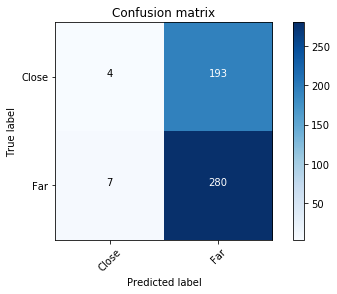

Accuracy: 0.5868
             precision    recall  f1-score   support

      Close       0.36      0.02      0.04       197
        Far       0.59      0.98      0.74       287

avg / total       0.50      0.59      0.45       484



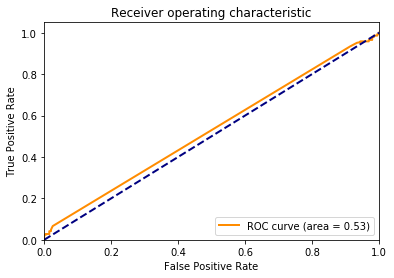

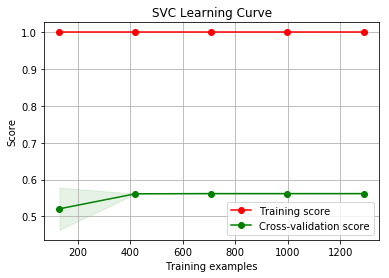

In [16]:
C_range = np.logspace(-3, 3, 7)
gamma_range = np.logspace(-3, 3, 7)
param_grid = dict(gamma=gamma_range, C=C_range)

classifier(model = SVC(random_state=0, probability=True, class_weight='balanced'),
           title = 'SVC',
           params = param_grid,
           feature_array = ('bookvalue', 'fcf', 'debt_to_equity', 'current_ratio', 'incomeQ', 'dividends', 'r_and_d', 'sector_classes'),
           single_feature_set=True,
           scoring = 'accuracy')

## Decision Tree

Using the same feature set from above, we get similar results with a Decision Tree. The accuracy decreases due to an imbalance between the values for Close and Far classes. AUC is comparable and the train and test sets converge, as seen in the learning curve. 

Feature set: ('bookvalue', 'fcf', 'debt_to_equity', 'current_ratio', 'incomeQ', 'dividends', 'r_and_d', 'sector_classes')
Parameters: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 2, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': 0, 'splitter': 'best'}
Training Data Accuracy: 0.58
Test Data Accuracy:     0.55


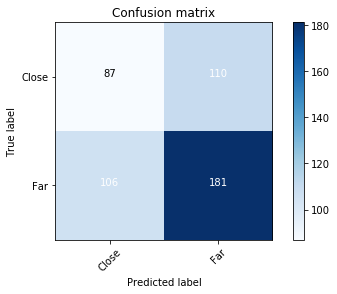

Accuracy: 0.5537
             precision    recall  f1-score   support

      Close       0.45      0.44      0.45       197
        Far       0.62      0.63      0.63       287

avg / total       0.55      0.55      0.55       484



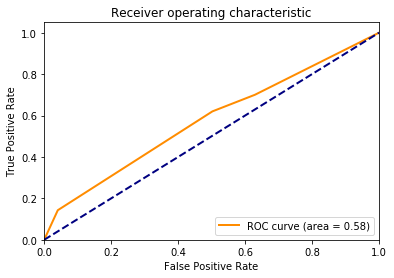

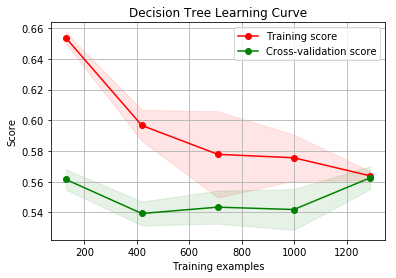

In [17]:
classifier(model = DecisionTreeClassifier(random_state=0, max_features='auto', class_weight='balanced'),
           title = 'Decision Tree',
           params = {'criterion':['gini', 'entropy'], 'max_depth':[k for k in range(1,X.shape[1]-2)]},
           feature_array = ('bookvalue', 'fcf', 'debt_to_equity', 'current_ratio', 'incomeQ', 'dividends', 'r_and_d', 'sector_classes'),
           single_feature_set=True,
           scoring = 'accuracy')

Decision Trees for each feature set (none stand out too much)

Feature set: ('bookvalue', 'fcf', 'debt_equity', 'currentR', 'incomeQ', 'dividends', 'r_and_d', 'sector_classes')
Parameters: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 2, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': 0, 'splitter': 'best'}
Training Data Accuracy: 0.58
Test Data Accuracy:     0.55


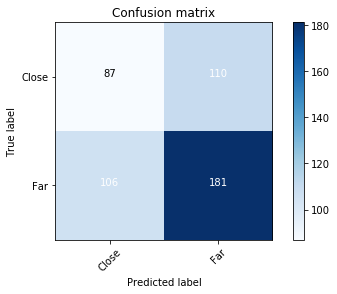

Accuracy: 0.5537
             precision    recall  f1-score   support

      Close       0.45      0.44      0.45       197
        Far       0.62      0.63      0.63       287

avg / total       0.55      0.55      0.55       484



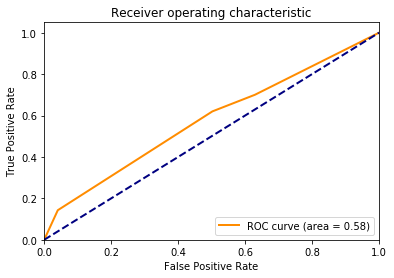

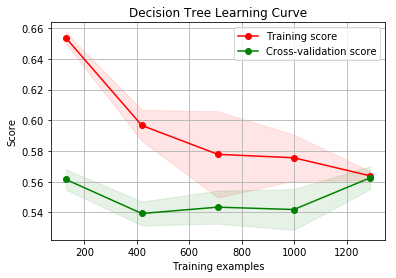

Feature set: ('bookvalue', 'fcf', 'debt_equity', 'currentR', 'income_quality', 'dividends', 'r_and_d', 'sector_classes')
Parameters: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 2, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': 0, 'splitter': 'best'}
Training Data Accuracy: 0.58
Test Data Accuracy:     0.55


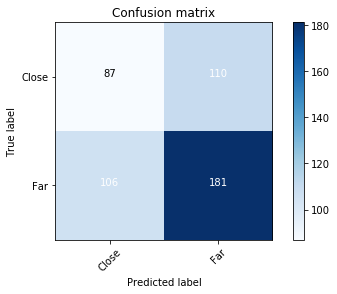

Accuracy: 0.5537
             precision    recall  f1-score   support

      Close       0.45      0.44      0.45       197
        Far       0.62      0.63      0.63       287

avg / total       0.55      0.55      0.55       484



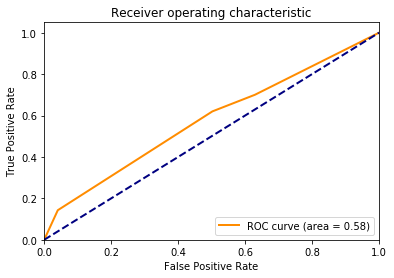

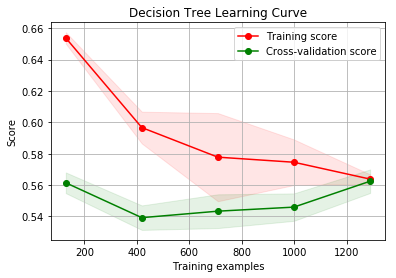

Feature set: ('bookvalue', 'fcf', 'debt_equity', 'current_ratio', 'incomeQ', 'dividends', 'r_and_d', 'sector_classes')
Parameters: {'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': 0, 'splitter': 'best'}
Training Data Accuracy: 0.61
Test Data Accuracy:     0.58


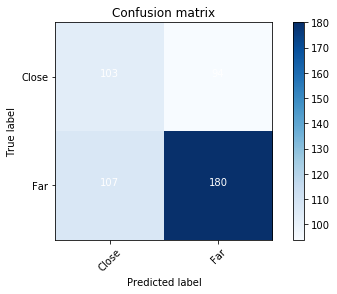

Accuracy: 0.5847
             precision    recall  f1-score   support

      Close       0.49      0.52      0.51       197
        Far       0.66      0.63      0.64       287

avg / total       0.59      0.58      0.59       484



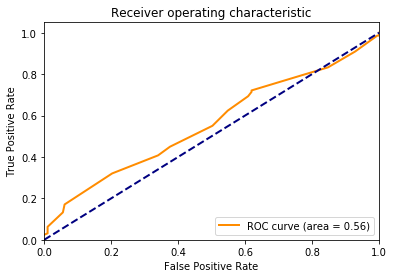

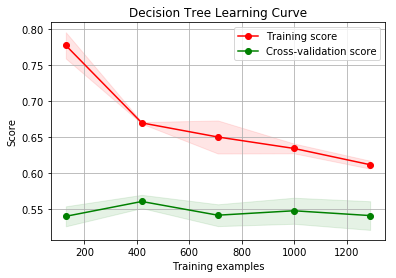

Feature set: ('bookvalue', 'fcf', 'debt_equity', 'current_ratio', 'income_quality', 'dividends', 'r_and_d', 'sector_classes')
Parameters: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 4, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': 0, 'splitter': 'best'}
Training Data Accuracy: 0.60
Test Data Accuracy:     0.56


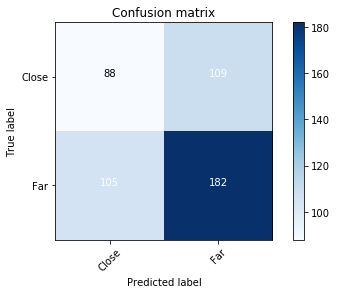

Accuracy: 0.5579
             precision    recall  f1-score   support

      Close       0.46      0.45      0.45       197
        Far       0.63      0.63      0.63       287

avg / total       0.56      0.56      0.56       484



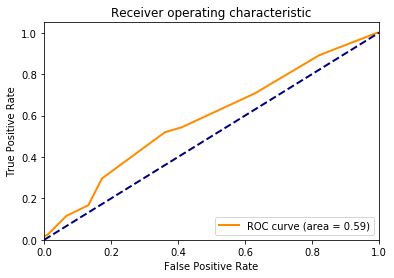

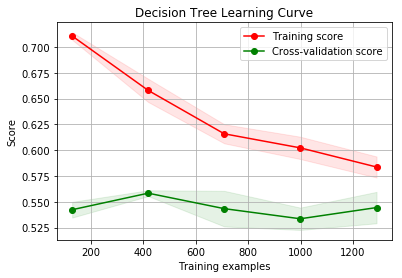

Feature set: ('bookvalue', 'fcf', 'debt_to_equity', 'currentR', 'incomeQ', 'dividends', 'r_and_d', 'sector_classes')
Parameters: {'class_weight': None, 'criterion': 'gini', 'max_depth': 4, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': 0, 'splitter': 'best'}
Training Data Accuracy: 0.60
Test Data Accuracy:     0.55


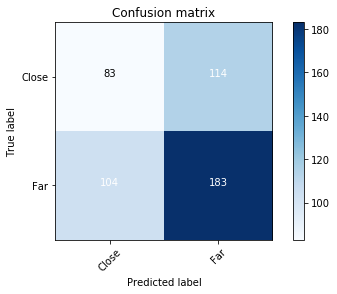

Accuracy: 0.5496
             precision    recall  f1-score   support

      Close       0.44      0.42      0.43       197
        Far       0.62      0.64      0.63       287

avg / total       0.55      0.55      0.55       484



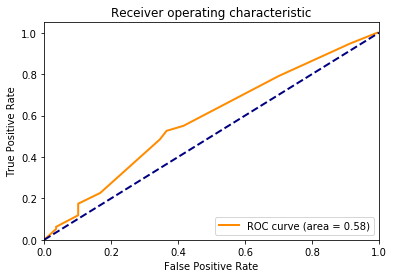

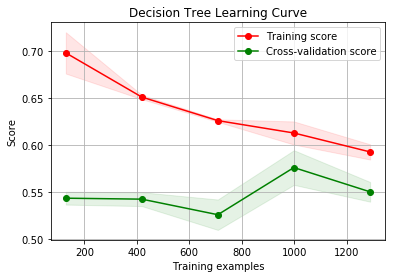

Feature set: ('bookvalue', 'fcf', 'debt_to_equity', 'currentR', 'income_quality', 'dividends', 'r_and_d', 'sector_classes')
Parameters: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 4, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': 0, 'splitter': 'best'}
Training Data Accuracy: 0.59
Test Data Accuracy:     0.56


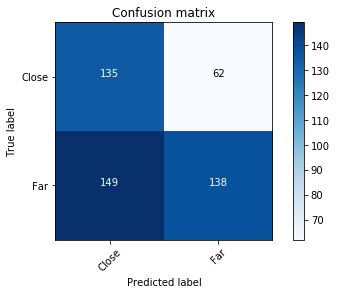

Accuracy: 0.5640
             precision    recall  f1-score   support

      Close       0.48      0.69      0.56       197
        Far       0.69      0.48      0.57       287

avg / total       0.60      0.56      0.56       484



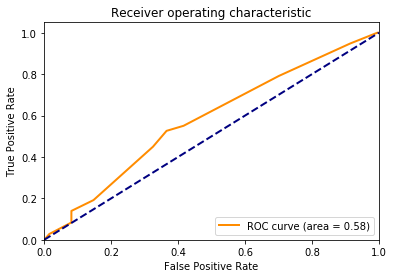

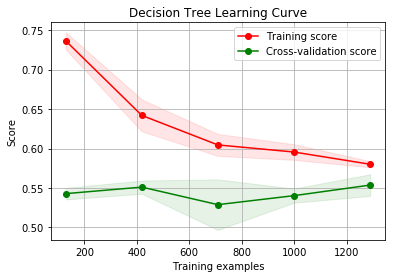

Feature set: ('bookvalue', 'fcf', 'debt_to_equity', 'current_ratio', 'incomeQ', 'dividends', 'r_and_d', 'sector_classes')
Parameters: {'class_weight': None, 'criterion': 'gini', 'max_depth': 4, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': 0, 'splitter': 'best'}
Training Data Accuracy: 0.61
Test Data Accuracy:     0.57


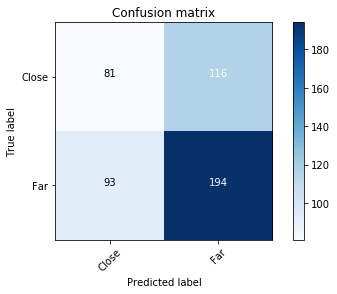

Accuracy: 0.5682
             precision    recall  f1-score   support

      Close       0.47      0.41      0.44       197
        Far       0.63      0.68      0.65       287

avg / total       0.56      0.57      0.56       484



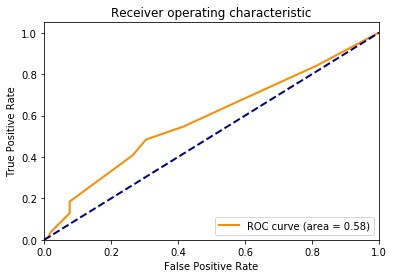

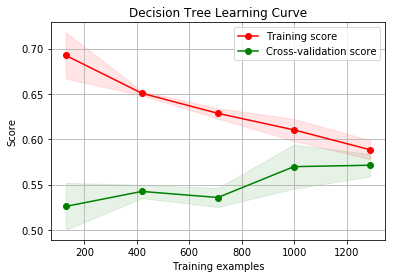

Feature set: ('bookvalue', 'fcf', 'debt_to_equity', 'current_ratio', 'income_quality', 'dividends', 'r_and_d', 'sector_classes')
Parameters: {'class_weight': None, 'criterion': 'gini', 'max_depth': 4, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': 0, 'splitter': 'best'}
Training Data Accuracy: 0.61
Test Data Accuracy:     0.57


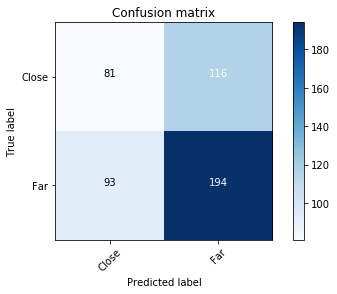

Accuracy: 0.5682
             precision    recall  f1-score   support

      Close       0.47      0.41      0.44       197
        Far       0.63      0.68      0.65       287

avg / total       0.56      0.57      0.56       484



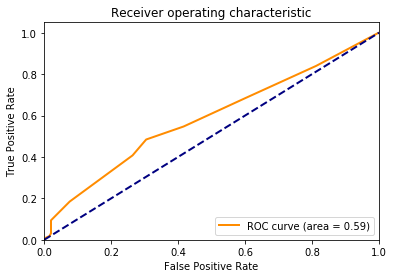

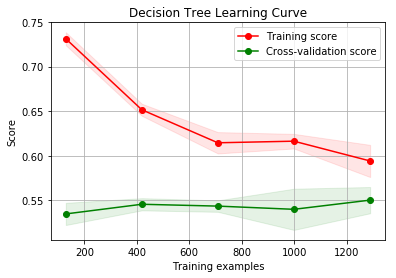

Feature set: ('bookvalue', 'free_cash_flow', 'debt_equity', 'currentR', 'incomeQ', 'dividends', 'r_and_d', 'sector_classes')
Parameters: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 3, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': 0, 'splitter': 'best'}
Training Data Accuracy: 0.59
Test Data Accuracy:     0.55


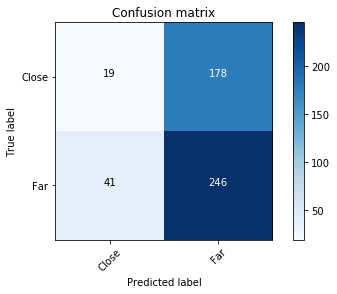

Accuracy: 0.5475
             precision    recall  f1-score   support

      Close       0.32      0.10      0.15       197
        Far       0.58      0.86      0.69       287

avg / total       0.47      0.55      0.47       484



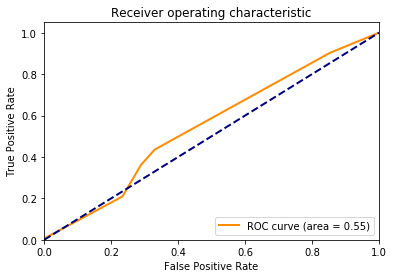

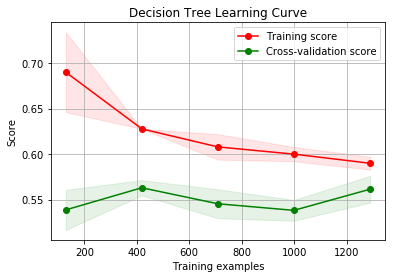

Feature set: ('bookvalue', 'free_cash_flow', 'debt_equity', 'currentR', 'income_quality', 'dividends', 'r_and_d', 'sector_classes')
Parameters: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 3, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': 0, 'splitter': 'best'}
Training Data Accuracy: 0.59
Test Data Accuracy:     0.55


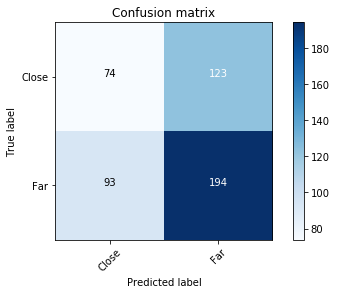

Accuracy: 0.5537
             precision    recall  f1-score   support

      Close       0.44      0.38      0.41       197
        Far       0.61      0.68      0.64       287

avg / total       0.54      0.55      0.55       484



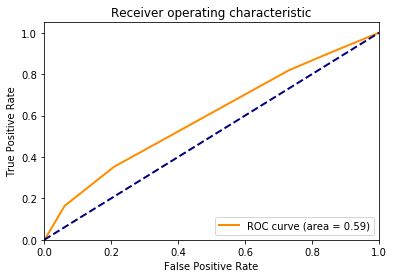

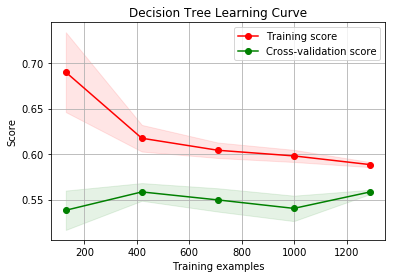

Feature set: ('bookvalue', 'free_cash_flow', 'debt_equity', 'current_ratio', 'incomeQ', 'dividends', 'r_and_d', 'sector_classes')
Parameters: {'class_weight': None, 'criterion': 'gini', 'max_depth': 2, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': 0, 'splitter': 'best'}
Training Data Accuracy: 0.56
Test Data Accuracy:     0.52


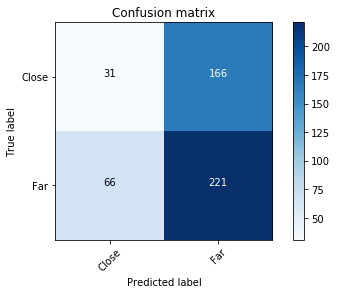

Accuracy: 0.5207
             precision    recall  f1-score   support

      Close       0.32      0.16      0.21       197
        Far       0.57      0.77      0.66       287

avg / total       0.47      0.52      0.47       484



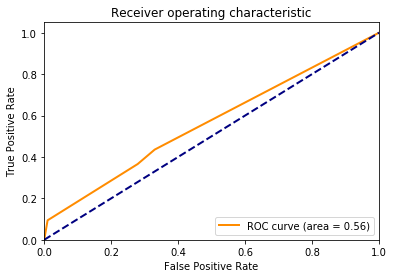

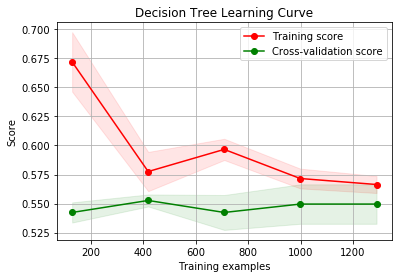

Feature set: ('bookvalue', 'free_cash_flow', 'debt_equity', 'current_ratio', 'income_quality', 'dividends', 'r_and_d', 'sector_classes')
Parameters: {'class_weight': None, 'criterion': 'gini', 'max_depth': 2, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': 0, 'splitter': 'best'}
Training Data Accuracy: 0.57
Test Data Accuracy:     0.53


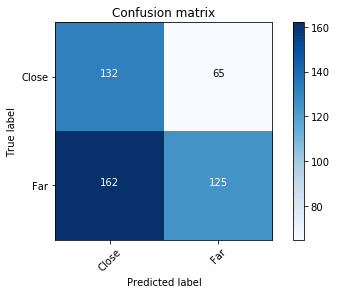

Accuracy: 0.5310
             precision    recall  f1-score   support

      Close       0.45      0.67      0.54       197
        Far       0.66      0.44      0.52       287

avg / total       0.57      0.53      0.53       484



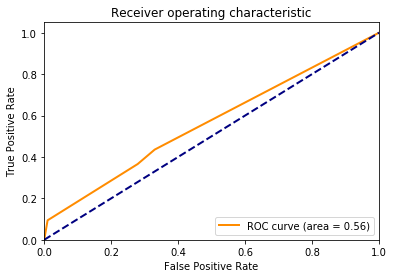

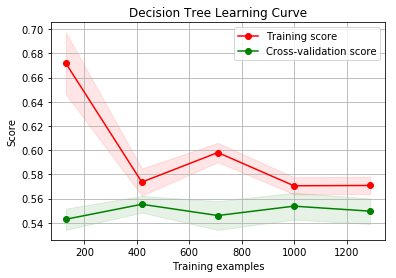

Feature set: ('bookvalue', 'free_cash_flow', 'debt_to_equity', 'currentR', 'incomeQ', 'dividends', 'r_and_d', 'sector_classes')
Parameters: {'class_weight': None, 'criterion': 'gini', 'max_depth': 3, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': 0, 'splitter': 'best'}
Training Data Accuracy: 0.59
Test Data Accuracy:     0.55


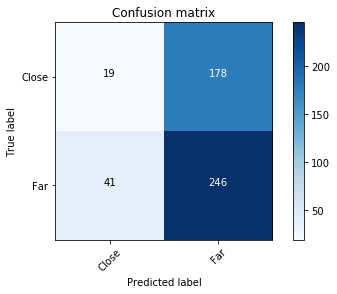

Accuracy: 0.5475
             precision    recall  f1-score   support

      Close       0.32      0.10      0.15       197
        Far       0.58      0.86      0.69       287

avg / total       0.47      0.55      0.47       484



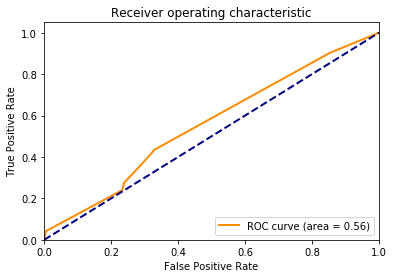

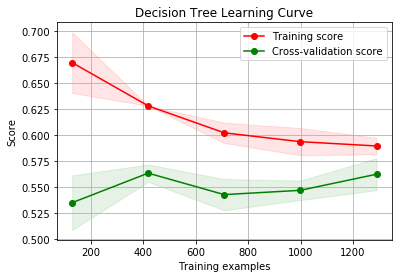

Feature set: ('bookvalue', 'free_cash_flow', 'debt_to_equity', 'currentR', 'income_quality', 'dividends', 'r_and_d', 'sector_classes')
Parameters: {'class_weight': None, 'criterion': 'gini', 'max_depth': 4, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': 0, 'splitter': 'best'}
Training Data Accuracy: 0.60
Test Data Accuracy:     0.54


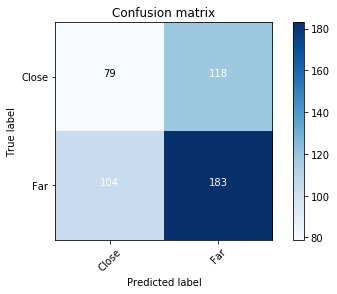

Accuracy: 0.5413
             precision    recall  f1-score   support

      Close       0.43      0.40      0.42       197
        Far       0.61      0.64      0.62       287

avg / total       0.54      0.54      0.54       484



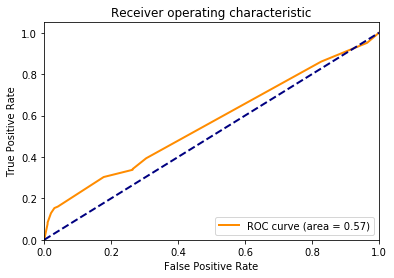

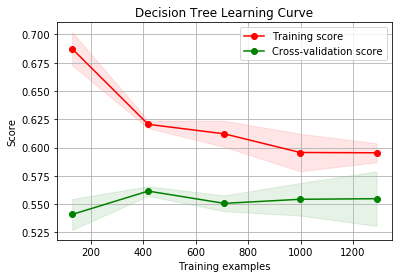

Feature set: ('bookvalue', 'free_cash_flow', 'debt_to_equity', 'current_ratio', 'incomeQ', 'dividends', 'r_and_d', 'sector_classes')
Parameters: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 5, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': 0, 'splitter': 'best'}
Training Data Accuracy: 0.59
Test Data Accuracy:     0.55


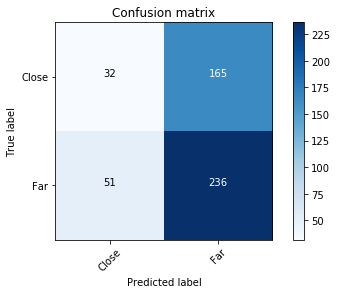

Accuracy: 0.5537
             precision    recall  f1-score   support

      Close       0.39      0.16      0.23       197
        Far       0.59      0.82      0.69       287

avg / total       0.51      0.55      0.50       484



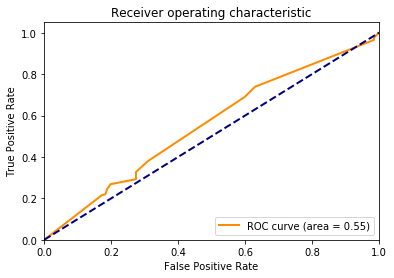

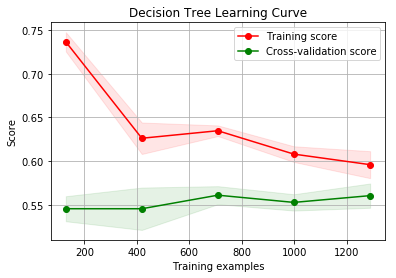

Feature set: ('bookvalue', 'free_cash_flow', 'debt_to_equity', 'current_ratio', 'income_quality', 'dividends', 'r_and_d', 'sector_classes')
Parameters: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 4, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': 0, 'splitter': 'best'}
Training Data Accuracy: 0.58
Test Data Accuracy:     0.51


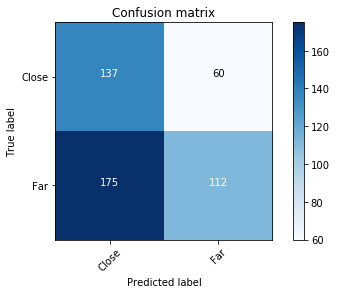

Accuracy: 0.5145
             precision    recall  f1-score   support

      Close       0.44      0.70      0.54       197
        Far       0.65      0.39      0.49       287

avg / total       0.56      0.51      0.51       484



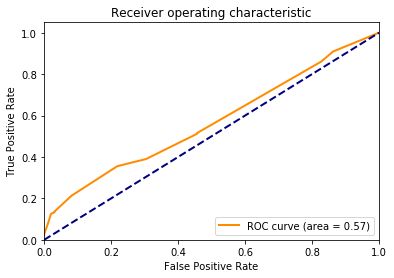

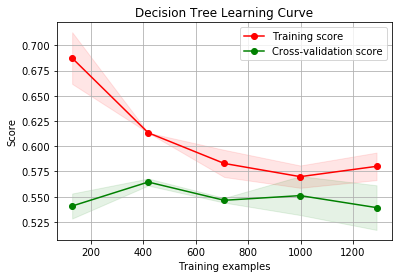

In [18]:
classifier(model = DecisionTreeClassifier(random_state=0, max_features='auto'),
           title = 'Decision Tree',
           params = {'class_weight': [None, 'balanced'], 'criterion':['gini', 'entropy'], 'max_depth':[k for k in range(1,X.shape[1]-2)]},
           feature_array = feature_list,
           single_feature_set=False,
           scoring = 'accuracy')

## Random Forest

The feature set from above does not perform particularly well with Random Forest. AUC is high, the sets converge, however, the classes are quite imbalanced.

Feature set: ('bookvalue', 'fcf', 'debt_to_equity', 'current_ratio', 'incomeQ', 'dividends', 'r_and_d', 'sector_classes')
Parameters: {'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 4, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}
Training Data Accuracy: 0.63
Test Data Accuracy:     0.55


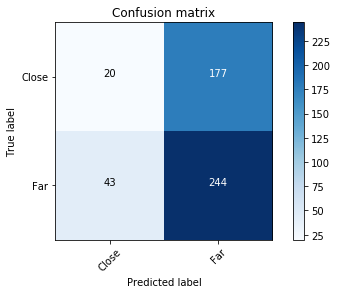

Accuracy: 0.5455
             precision    recall  f1-score   support

      Close       0.32      0.10      0.15       197
        Far       0.58      0.85      0.69       287

avg / total       0.47      0.55      0.47       484



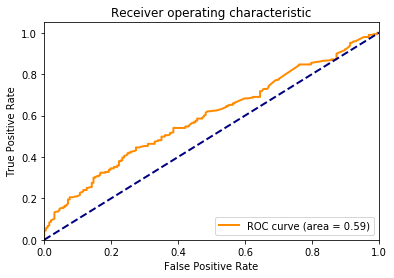

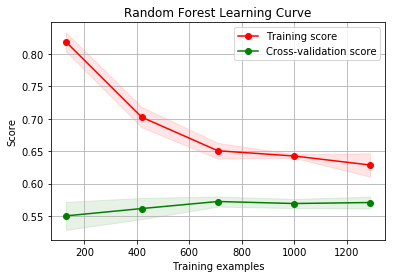

In [19]:
rf_params = {'max_depth': [x for x in range(1,6)],
             'n_estimators': [x for x in range(1,11)],
             'criterion': ['gini', 'entropy']
             }

classifier(model = RandomForestClassifier(random_state=0, class_weight='balanced'),
           title = 'Random Forest',
           params = rf_params,
           feature_array = ('bookvalue', 'fcf', 'debt_to_equity', 'current_ratio', 'incomeQ', 'dividends', 'r_and_d', 'sector_classes'),
           single_feature_set=True,
           scoring = 'accuracy')

Let's run Random Forest on all feature sets.

In [20]:
def random_forest(features, target):

    X = np.array(features)
    y = np.array(target)

    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.25, random_state=0)
    
    rf_params = {'max_depth': [x for x in range(1,int(len(features.columns)-2))],
                 'n_estimators': [x for x in range(1,11)],
                 'criterion': ['gini', 'entropy']
                 }
    rf_grid = GridSearchCV(RandomForestClassifier(random_state=0), rf_params, scoring='accuracy', cv=5, n_jobs=-1)
    
    rf_grid.fit(X_train, Y_train)
    
    best = rf_grid.best_estimator_
    
    y_pred = best.predict(X_test)
    
    y_score = best.predict_proba(X_test)[:,1]

    fpr, tpr,_ = roc_curve(Y_test, y_score)
    roc_auc = auc(fpr, tpr)
    
    
    return X, y, X_train, X_test, Y_train, Y_test, y_pred, best, roc_auc, y_score

## Best Model

This is by far (relative to this data and modeling) the best results I've gotten thus far. Accuracy exceeds 60%, close precision and recall are close to 50%, AUC is 0.63, and the train and test sets' scores converge fairly well. This will be my final model.

('bookvalue', 'free_cash_flow', 'debt_to_equity', 'current_ratio', 'incomeQ', 'dividends', 'r_and_d', 'sector_classes')
Best Parameters: {'bootstrap': True, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 5, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 6, 'n_jobs': 1, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}
             precision    recall  f1-score   support

      close       0.51      0.49      0.50       197
        far       0.66      0.68      0.67       287

avg / total       0.60      0.60      0.60       484

Accuracy: 0.6033057851239669

Feature Importance
bookvalue: 0.258154050099
free_cash_flow: 0.0630367272474
debt_to_equity: 0.0622299070188
current_ratio: 0.0725819449862
incomeQ: 0.256791069425
dividends: 0.044133898462
r_and_d: 0.0191725273676
sector_classes: 0.22389987539

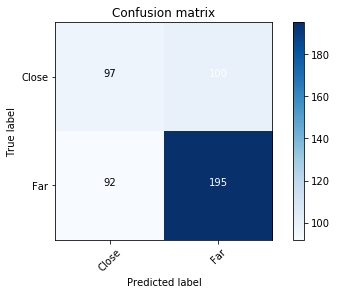

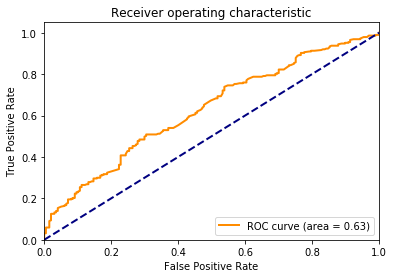

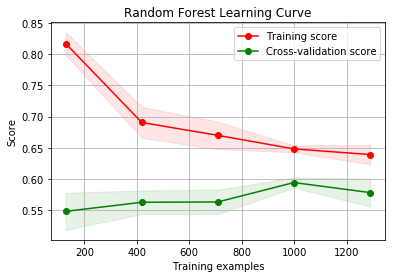

In [21]:
for feature in feature_list:

    X, y, X_train, X_test, Y_train, Y_test, y_pred, best_rf, roc_auc, y_score = random_forest(shuffle.loc[:, feature], shuffle.buckets)
    if feature == ('bookvalue', 'free_cash_flow', 'debt_to_equity', 'current_ratio', 'incomeQ', 'dividends', 'r_and_d', 'sector_classes'):
        print(feature)
        print('Best Parameters: {}'.format(best_rf.get_params()))
        
        print(classification_report(Y_test, y_pred, target_names=['close', 'far']))
        print('Accuracy: {}\n'.format(accuracy_score(Y_test, y_pred)))
        print('Feature Importance')
        for f,i in zip(feature, best_rf.feature_importances_):
            print('%s: %s' % (f,i))
        print('\n')
        cm = calculate_confusion_matrix(best_rf, X_train, Y_train, X_test, Y_test)
        plot_confusion_matrix(cm)
        plt.show()
        plot_roc_curve(Y_test, y_score)
        plot_learning_curve(best_rf, 'Random Forest', X, y)
    